In [1]:
#Allows relative imports
import os
import sys
import pandas as pd 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports 
from src.preprocessing import *
from src.models import *
from src.train_eval_helpers import *
from src.plots import *
import torch
import torch.nn as nn
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 300
import seaborn as sns
sns.set_style('darkgrid')

#checking gpu status
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))

RANGE = range(12,17)
TRAINDIR = '../TrainingData/'

Using : cuda


In [2]:
#Getting models
models = load_models('../output/training_output/richie_minmax_redo_withnograd/', arch = 'richie', eval_=True)
deepcats = load_models('../output/training_output/benchmark/', arch='deepcat', eval_=True)

Models & weights loaded
Models & weights loaded


In [3]:
def parse_tsv(filepath):
    temp = pd.read_csv(filepath, sep='\t', header = 0, usecols=['sample_name','amino_acid'])
    temp = temp.dropna()
    temp['len']= temp.apply(lambda x: len(x['amino_acid']),axis=1)
    temp = temp.query('(amino_acid.str.startswith("C") and amino_acid.str.endswith("F"))')
    temp = temp.query('not amino_acid.str.contains("\*")')
    temp = temp.query('len>=12 and len <=16')
    return temp

In [4]:
ostmeyer_tumor = '../NewData/ostmeyer_colorectal/tumor'
ostmeyer_mucosa = '../NewData/ostmeyer_colorectal/mucosa'
tumor_df = pd.DataFrame(columns= ['sample_name','amino_acid','len'])
mucosa_df = pd.DataFrame(columns= ['sample_name','amino_acid','len'])
for tumor, mucosa in zip(os.listdir(ostmeyer_tumor), os.listdir(ostmeyer_mucosa)):
    tumor_temp = parse_tsv(os.path.join(ostmeyer_tumor,tumor))
    tumor_df=tumor_df.append(tumor_temp, ignore_index=True)
    
    mucosa_temp = parse_tsv(os.path.join(ostmeyer_mucosa,mucosa))
    mucosa_df=mucosa_df.append(mucosa_temp, ignore_index=True)

In [6]:
tumor_seqs = tumor_df['amino_acid'].values
mucosa_seqs = mucosa_df['amino_acid'].values

dc_features, dc_labels = generate_features_labels(tumor_seqs, mucosa_seqs, keys=range(12,17),
                                                  encoding='aaidx', scaling =None)
rich_features, rich_labels = generate_features_labels(tumor_seqs, mucosa_seqs, encoding='aa_atchley', scaling = 'minmax')

Getting data
Data device = cpu
Done loading, returning features and labels.
Getting data
Data device = cpu
Done loading, returning features and labels.


In [8]:
_, dc_accs, dc_aucs, dc_f1, dc_curves = test_eval(deepcats,  dc_features, dc_labels, 
                                                  range(12,17), nn.CrossEntropyLoss(), return_curve=True)
_, rich_accs, rich_aucs, rich_f1, rich_curves =  test_eval(models,  rich_features, rich_labels, 
                                                           range(12,17), nn.CrossEntropyLoss(), return_curve=True)

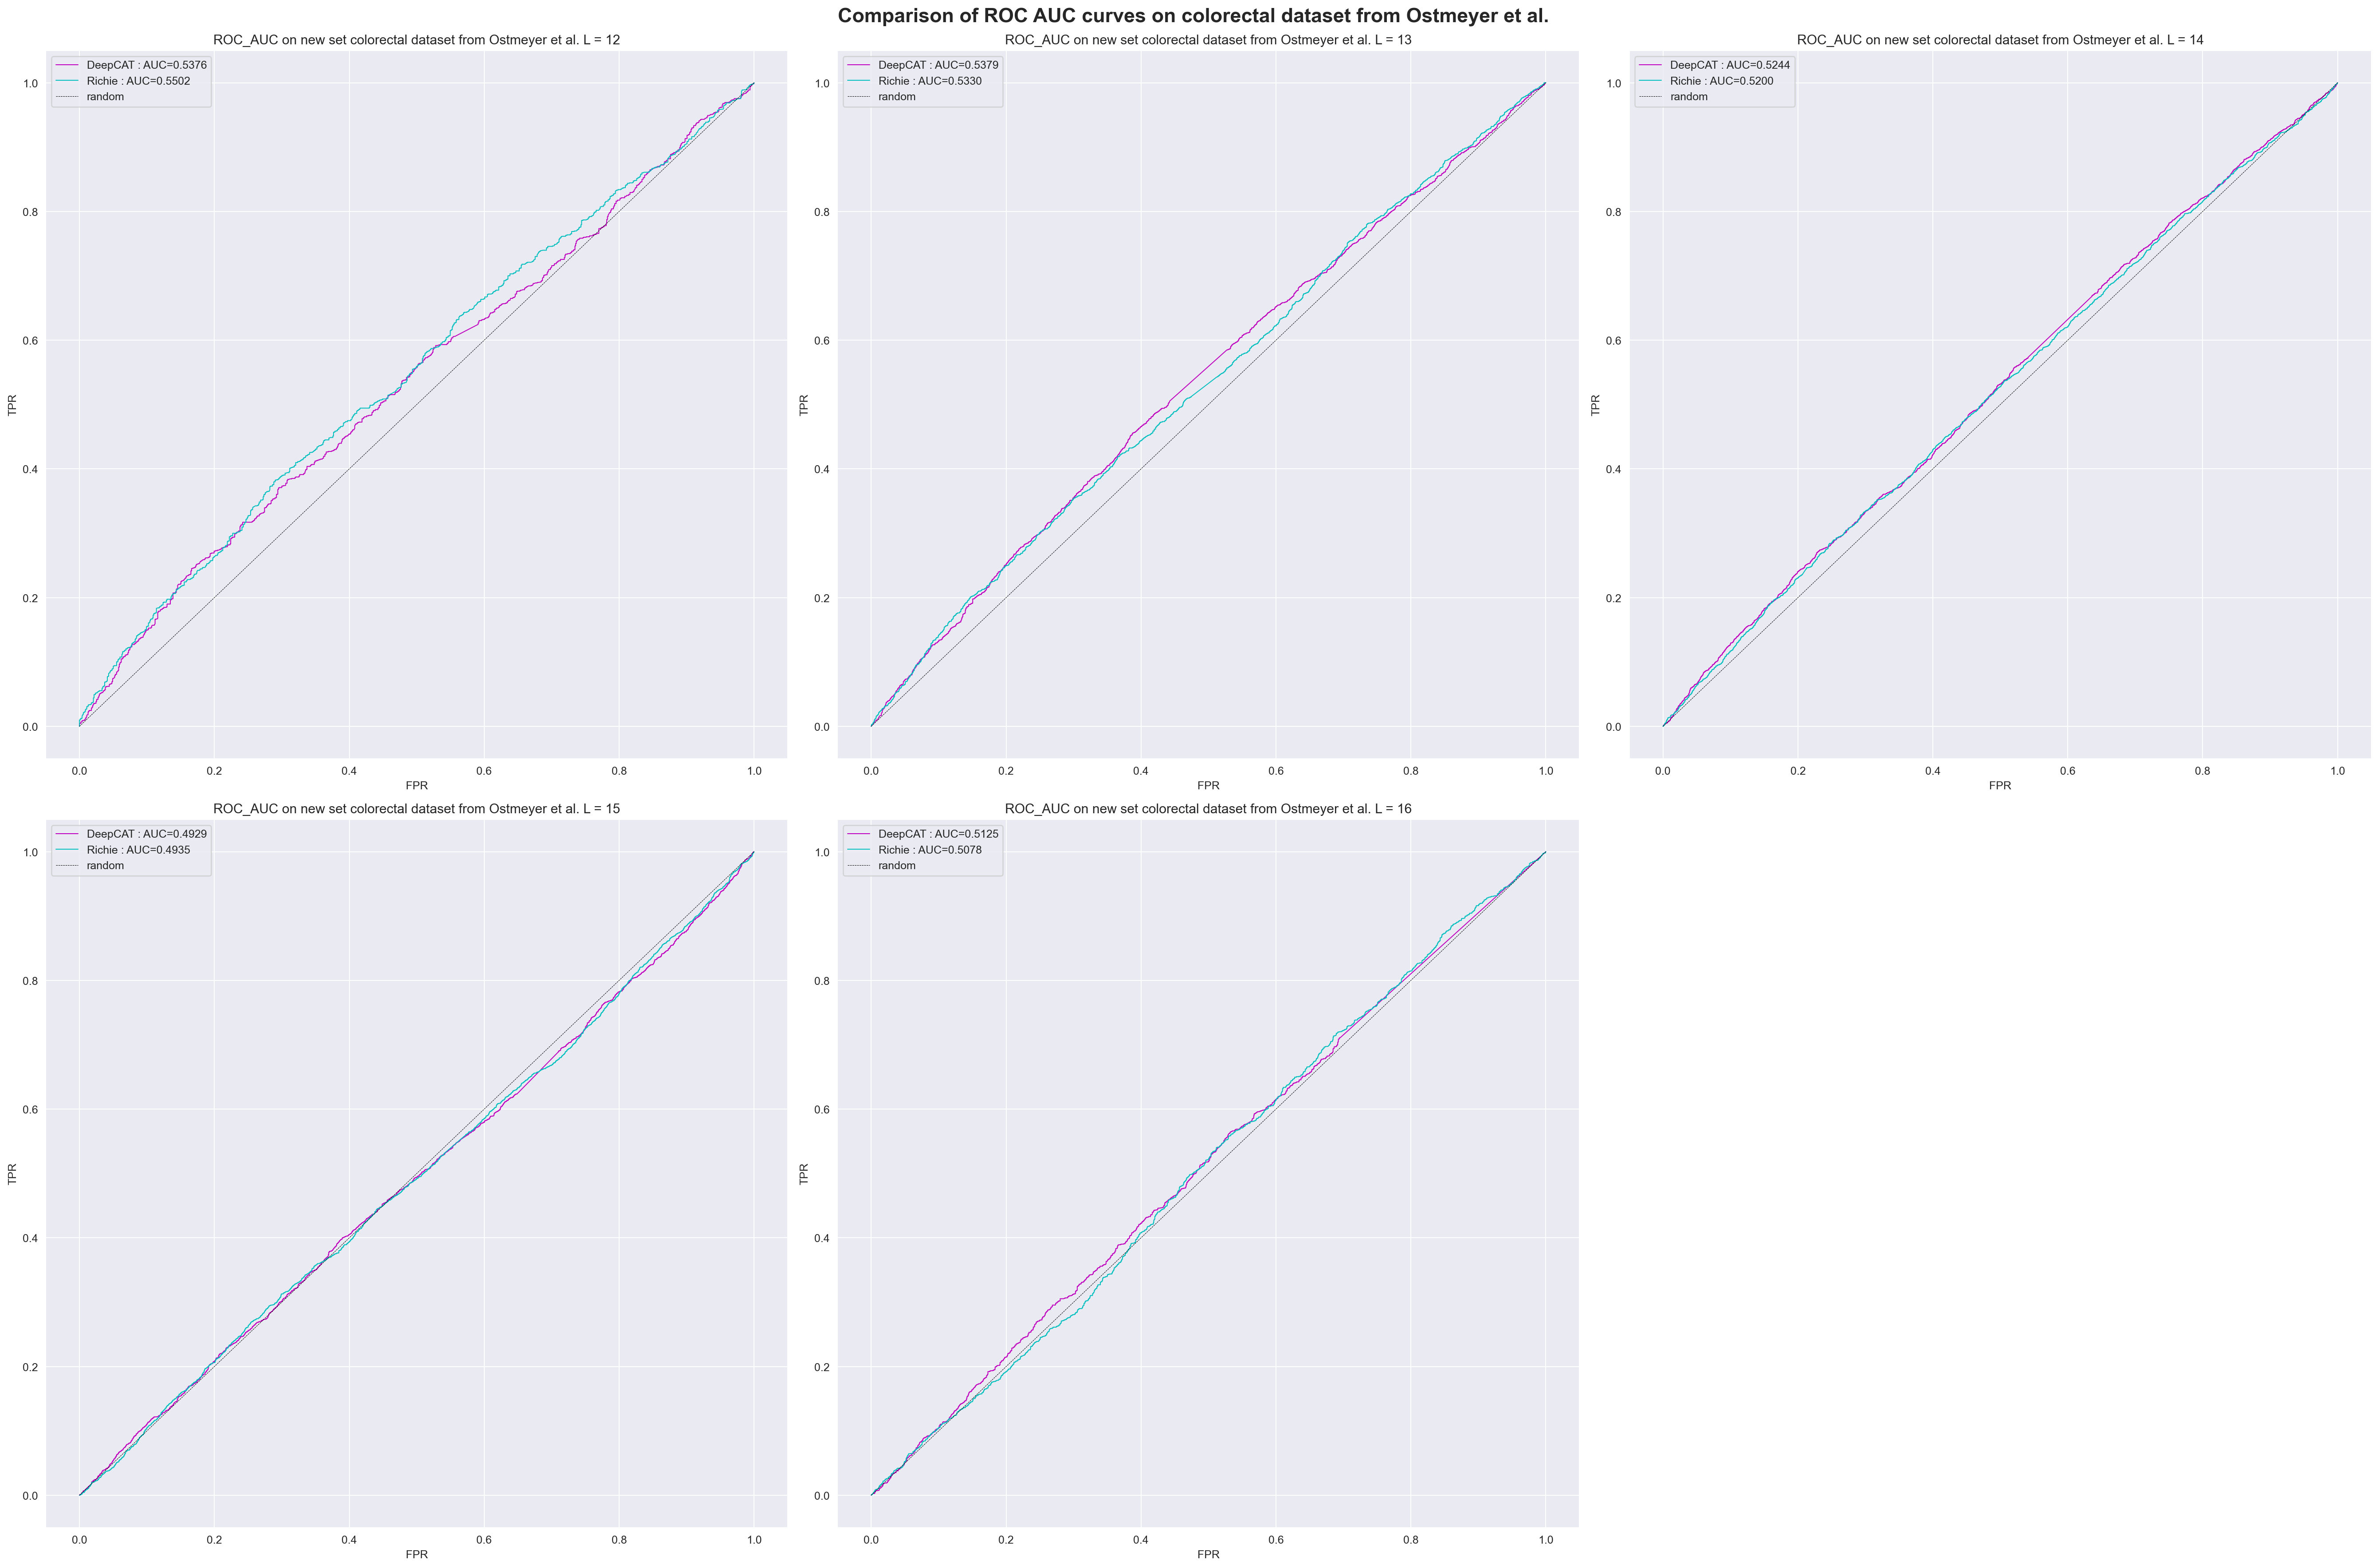

In [11]:

plot_roc_comparison(dc_curves, rich_curves,name='colorectal dataset from Ostmeyer et al.' ,save='colorectal_comparison.jpg')#, keys=range(12,17), save=None)